# Project Wrangle and Analyze Data

The dataset that will be used for wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates https://twitter.com/dog_rates/status/889531135344209921, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 9 million followers and has received international media coverage.

## Table of Contents
<ul>
<li><a href="#gathering">Gathering Data</a></li>
<li><a href="#assessing">Assessing Data</a></li>  
<li><a href="#cleaning">Cleaning Data</a></li>
<li><a href="#aav">Analysis and Viszualization</a></li>

In [43]:
# importing proposed libraries
import pandas as pd
import numpy as np
import requests
import json

<a id='gathering'></a>
## Gather data

Start with importing files to dataframes

In [7]:
# read twitter archive
df_tw_archive= pd.read_csv('twitter-archive-enhanced.csv')
df_tw_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
# read images
df_images= pd.read_csv('image-predictions.tsv', sep='\t')
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
# read tweets
#load the json data and store it in a list --> proposed solution in Udacity FAQs
data = []
with open('tweet-json.txt') as f:    
        for line in f:         
             data.append(json.loads(line))
#create dataframe from json data
df_api = pd.DataFrame(data)
df_api.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,False,False,en,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,False,False,en,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,False,False,en,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,False,False,en,NaN,NaN,NaN,NaN


In [10]:
#select columns of interest
columns_of_interest = ['id', 'retweet_count', 'favorite_count']
df_api = df_api[columns_of_interest]
df_api.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [11]:
# save api data to csv to analyze visually
df_api.to_csv('tweet_text.csv', index= False)

In [12]:
# save images to csv as well
df_images.to_csv('images.csv', index= False)

<a id='assessing'></a>
## Assess data

The following issues have been detected during assessment:


### Quality
#### tweets archive table
- The table contains data that is not available in the tweets table. Those should not be considered and deleted.
- The table contains data where no images exist. Those also should not be considered and can be deleted.
- The table not only contains orignal tweets but also retweets (column retweeted_status_id). Those entries can be deleted.
- The table not only contains orignal tweets but also replies (column in_reply_to_status_id). Those entries can be deleted.
- The "name" column is sometimes filled with dummy names like 'a', 'all', ... They should be removed and set to NULL 
- The "source" column values are difficult to understand. Instead of the complete phrase only the last part, e.g. "Twitter for iPhone" should be used 

    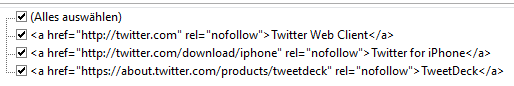
- The url column is not always filled. Those entries should only be considered if an image link is available
- The timestamp is of type string. This will be changed to date

#### images table
- There are rows where all proposed pictures are flagged as not beeing a dog (p1_dog, p2_dog, p3_dog = FALSE). Those entries can be deleted.


### Tidiness
- After deleting not needed data out of the archive table not needed columns for retweets and replies can be dropped (status, user, date)
- The columns for for dog stages (doggo, floofer, pupper, puppo) have the same values as the column names. They will be harmonized to one column. Some rows have entries for more than one of those column. When checking some of the pictures they always had more than one dog. So the target ist to combine the column values.
- As for all 3 tables the key is always the tweet-ID and there is no data on a different level at the end the 3 data sets will be combined to one.

#### The details of the analysis can be find below! 

### Assessing the tweets archive

In [13]:
df_tw_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [14]:
df_tw_archive.info()
df_tw_archive.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


#### Retweets and replies
- 78 entries are replies and can be deleted
- 181 entries are retweets and can be deleted
- only 2297 rows have urls, this will be checked again after joining the data

#### Data types
- datatype for timestamp should be set to date

#### Wrong dog names
The following names seem not to be a real name and shoud be set to 'None' instead: 

a, the, an, not, getting, mad, all, light, his, old, my, such. 

I confirmed this by checking some of the tweets.


In [8]:
pd.set_option("display.max_rows", None)
df_tw_archive.name.value_counts()

None              745
a                  55
Charlie            12
Lucy               11
Oliver             11
Cooper             11
Penny              10
Tucker             10
Lola               10
Bo                  9
Winston             9
the                 8
Sadie               8
an                  7
Toby                7
Daisy               7
Bailey              7
Buddy               7
Scout               6
Dave                6
Leo                 6
Jax                 6
Milo                6
Koda                6
Oscar               6
Rusty               6
Jack                6
Stanley             6
Bella               6
Oakley              5
very                5
Phil                5
Sunny               5
Alfie               5
George              5
Bentley             5
Louis               5
Finn                5
Larry               5
Chester             5
Sammy               5
Gus                 5
Reginald            4
Walter              4
Clarence            4
Winnie    

In [15]:
# names that should be deleted
name_check= ['a','the','an','not','getting','mad','all','light','his','old','my','such']

In [16]:
# double check with tweets are affected and do some checks in Twitter to confirm that the name is really wrong
df_tw_archive[df_tw_archive.name.isin(name_check)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,not,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
682,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to mad pupper. You kn...,7.363926e+17,4.196984e+09,2016-05-28 03:04:00 +0000,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,mad,None,None,pupper,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None


#### Finally check values for the source of the tweets
Target is to make them easier to understand. Final value list should be:
- Twitter for iPhone
- Vine - Make a Scene
- Twitter Web Client
- TweetDeck

In [26]:
df_tw_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [27]:
# You do not need to gather the tweets beyond August 1st, 2017. Check if there is newer data that should be deleted
df_tw_archive.timestamp.max() # ok, newest value from 1.8.2017

'2017-08-01 16:23:56 +0000'

### Assessing image table

In [19]:
df_images

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [20]:
df_images.info()
df_images.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### Checking entries without fitting pictures
If there are entries where none of the pictures are expected to be a dog, they can be deleted. This should be done before joining the data.
324 images are not identified to be a dog. Example: https://pbs.twimg.com/media/CUize-0WEAAerAK.jpg

Additionally I only want to keep one picture per dog. This should be the one with the highest probability that is confirmed being a dog. 543 entries have no dog picture in the first entry. Out of those 388 entries have no dog picture in the second entry. Out of those 64 have a dog in the third entry. This is in line with the 324 entries not having a dog picture at all

In [28]:
# check entries without image at all
no_image= df_images[df_images.p1_dog== False]
no_image= no_image[no_image.p2_dog== False]
no_image= no_image[no_image.p3_dog== False]

no_image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 6 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  324 non-null    int64  
 1   jpg_url   324 non-null    object 
 2   img_num   324 non-null    int64  
 3   p1        324 non-null    object 
 4   p1_conf   324 non-null    float64
 5   p1_dog    324 non-null    bool   
 6   p2        324 non-null    object 
 7   p2_conf   324 non-null    float64
 8   p2_dog    324 non-null    bool   
 9   p3        324 non-null    object 
 10  p3_conf   324 non-null    float64
 11  p3_dog    324 non-null    bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 26.3+ KB


In [29]:
# check which pictures should be considered in the final dataframe

df_images.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

### Assessing api data
As the dataframe is already reduced to 3 columns there are not issues to clean

In [34]:
df_api.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [35]:
df_api.info()
df_api.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


## Number of entries in each dataframe:
- df_api: 2354
- df_tw_archive: 2356
- df_images: 2075

It should be enough to join the dataframes by inner joins to get rid of missing entries. Before doing it entries out of the image table should be deleted that are not identified as being dogs.

<a id='cleaning'></a>
## Cleaning data

Start with importing files to dataframes

In [1]:
# importing proposed libraries
import pandas as pd
import numpy as np

In [2]:
# read files and copy them before cleaning
df_tw_archive= pd.read_csv('twitter-archive-enhanced.csv')
df_tweets= pd.read_csv('tweets.csv')
df_images= pd.read_csv('images.csv')

In [3]:
# copy datasets before starting to clean
df_tw_archive_clean= df_tw_archive.copy()
df_tweets_clean= df_tweets.copy()
df_images_clean= df_images.copy()

## Cleaning Sequences

The following sequence will be used:

1. Delete rows out of images that have been identified as not beeing dogs.
2. Delete rows out of tweet archive that are retweets
3. Delete rows out of tweet archive that are replies
4. Drop retweet and reply columns in tweet archive
5. Combine the columns doggo, floofer, pupper, puppo to a new column dog_stages and fill it with appropriate values
6. Change the timestamp datatype to date
7. Make the source column more readable
8. Delete dog names not identified as being a name
9. Join all 3 dataframes to one (inner join)
10. Check if url column is always filled
11. Check activities to make the dataframe better readable (changing column names, reordering...)

### 1. Delete rows out of images that have been identified as not being dogs.

In [20]:
# get lines where no dog is identified at all
no_image= df_images_clean[df_images_clean.p1_dog== False]
no_image= no_image[no_image.p2_dog== False]
no_image= no_image[no_image.p3_dog== False]

no_image.info()
no_image.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  0 non-null      int64  
 1   jpg_url   0 non-null      object 
 2   img_num   0 non-null      int64  
 3   p1        0 non-null      object 
 4   p1_conf   0 non-null      float64
 5   p1_dog    0 non-null      bool   
 6   p2        0 non-null      object 
 7   p2_conf   0 non-null      float64
 8   p2_dog    0 non-null      bool   
 9   p3        0 non-null      object 
 10  p3_conf   0 non-null      float64
 11  p3_dog    0 non-null      bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 0.0+ bytes


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [21]:
# create new column in df_images_clean to store the information if a picture is available
df_images_clean['no_pic']= df_images_clean['tweet_id'].isin(no_image['tweet_id'])

In [22]:
df_images_clean.no_pic.value_counts()

False    1751
Name: no_pic, dtype: int64

In [23]:
# and now only keep those rows where no_pic= False
df_images_clean= df_images_clean[df_images_clean['no_pic']== False]


In [24]:
df_images_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,no_pic
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,False
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,False
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,False
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,False
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,False


In [25]:
df_images_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1751 non-null   int64  
 1   jpg_url   1751 non-null   object 
 2   img_num   1751 non-null   int64  
 3   p1        1751 non-null   object 
 4   p1_conf   1751 non-null   float64
 5   p1_dog    1751 non-null   bool   
 6   p2        1751 non-null   object 
 7   p2_conf   1751 non-null   float64
 8   p2_dog    1751 non-null   bool   
 9   p3        1751 non-null   object 
 10  p3_conf   1751 non-null   float64
 11  p3_dog    1751 non-null   bool   
 12  no_pic    1751 non-null   bool   
dtypes: bool(4), float64(3), int64(2), object(4)
memory usage: 143.6+ KB


In [26]:
# drop column no_pic
df_images_clean= df_images_clean.drop(['no_pic'], axis=1)

In [27]:
df_images_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1751 non-null   int64  
 1   jpg_url   1751 non-null   object 
 2   img_num   1751 non-null   int64  
 3   p1        1751 non-null   object 
 4   p1_conf   1751 non-null   float64
 5   p1_dog    1751 non-null   bool   
 6   p2        1751 non-null   object 
 7   p2_conf   1751 non-null   float64
 8   p2_dog    1751 non-null   bool   
 9   p3        1751 non-null   object 
 10  p3_conf   1751 non-null   float64
 11  p3_dog    1751 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 141.9+ KB


In [28]:
# save images to csv as well
df_images_clean.to_csv('images_clean.csv', index= False)

## 2. Delete rows out of tweet archive that are retweets

In [40]:
df_tw_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [41]:
# only consider those tweets where the column retweeted_status_id is null
df_tw_archive_clean.retweeted_status_id.isna().value_counts()

True     2175
False     181
Name: retweeted_status_id, dtype: int64

In [42]:
df_tw_archive_clean = df_tw_archive_clean[df_tw_archive_clean.retweeted_status_id.isna()]

In [43]:
df_tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

## 3. Delete rows out of tweet archive that are replies 

In [44]:
# only consider those tweets where the column in_reply_to_status_id is null
df_tw_archive_clean.in_reply_to_status_id.isna().value_counts()

True     2097
False      78
Name: in_reply_to_status_id, dtype: int64

In [45]:
df_tw_archive_clean = df_tw_archive_clean[df_tw_archive_clean.in_reply_to_status_id.isna()]

In [46]:
df_tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

## 4. Drop retweet and reply colums

After deleting retweets and replies the corresponding columns are null always and can now be dropped.

In [47]:
df_tw_archive_clean = df_tw_archive_clean.drop(['retweeted_status_id',
                                    'retweeted_status_user_id',
                                    'retweeted_status_timestamp'], axis = 1)

In [48]:
df_tw_archive_clean = df_tw_archive_clean.drop(['in_reply_to_status_id',
                                    'in_reply_to_user_id'], axis = 1)


In [49]:
df_tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


In [50]:
#before starting with further cleaning the dataframe will be saved, just in case...
# save images to csv as well
df_tw_archive_clean.to_csv('tw_archive_clean.csv', index= False)

## 5. Combine the columns doggo, floofer, pupper, puppo to a new column dog_stages and fill it with appropriate values

#### To consider
There are tweets where more than one column is filled. In some pictures this is correct, because there is more than one dog, in others not.

#### Approach
- Replace value 'None' by blank to get a better overview
- Create a new column dog_stages and combine the correct values in this column
- Manually check the pictures on twitter and fill with correct values 
- drop the intermediate column

In [51]:
# First all entries with 'None' will be set to empty
df_tw_archive_clean.doggo.replace('None', '', inplace=True)
df_tw_archive_clean.floofer.replace('None', '', inplace=True)
df_tw_archive_clean.pupper.replace('None', '', inplace=True)
df_tw_archive_clean.puppo.replace('None', '', inplace=True)

df_tw_archive_clean.head(20)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,,,
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,,,
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,,,
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,,,,
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,,,,
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,,,,
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,,,,
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,,,


In [52]:
# create new column dog_stage and merge columns
df_tw_archive_clean['dog_stages'] = df_tw_archive_clean.doggo + df_tw_archive_clean.floofer + df_tw_archive_clean.pupper + df_tw_archive_clean.puppo

In [53]:
df_tw_archive_clean.dog_stages.value_counts()

                1761
pupper           221
doggo             72
puppo             23
floofer            9
doggopupper        9
doggofloofer       1
doggopuppo         1
Name: dog_stages, dtype: int64

In [54]:
# manually check correct values for doggopupper, doggopuppo, doggofloofer
df_tw_archive_clean[df_tw_archive_clean['dog_stages']== 'doggopupper']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stages
460,817777686764523521,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,,pupper,,doggopupper
531,808106460588765185,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,,pupper,,doggopupper
575,801115127852503040,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,,pupper,,doggopupper
705,785639753186217984,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,,pupper,,doggopupper
733,781308096455073793,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,,pupper,,doggopupper
889,759793422261743616,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,doggo,,pupper,,doggopupper
956,751583847268179968,2016-07-09 01:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,https://twitter.com/dog_rates/status/751583847...,5,10,None,doggo,,pupper,,doggopupper
1063,741067306818797568,2016-06-10 00:39:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,,pupper,,doggopupper
1113,733109485275860992,2016-05-19 01:38:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like father (doggo), like son (pupper). Both 1...",https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,,pupper,,doggopupper


In [55]:
# try with first line which is a pupper only
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 817777686764523521, 'dog_stages'] = 'pupper'

In [56]:
df_tw_archive_clean[df_tw_archive_clean.tweet_id == 817777686764523521]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stages
460,817777686764523521,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,,pupper,,pupper


In [57]:
# continue with other tweets checking
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 801115127852503040, 'dog_stages'] = 'pupper'
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 808106460588765185, 'dog_stages'] = 'doggo, pupper'
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 801115127852503040, 'dog_stages'] = 'pupper'
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 785639753186217984, 'dog_stages'] = ''
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 781308096455073793, 'dog_stages'] = 'doggo, pupper'
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 759793422261743616, 'dog_stages'] = 'doggo, pupper'
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 751583847268179968, 'dog_stages'] = 'doggo'
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 741067306818797568, 'dog_stages'] = 'doggo, pupper'
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 733109485275860992, 'dog_stages'] = 'doggo, pupper'

In [58]:
df_tw_archive_clean.dog_stages.value_counts()

                 1762
pupper            223
doggo              73
puppo              23
floofer             9
doggo, pupper       5
doggofloofer        1
doggopuppo          1
Name: dog_stages, dtype: int64

In [59]:
df_tw_archive_clean[df_tw_archive_clean['dog_stages']== 'doggopuppo']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stages
191,855851453814013952,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,,,puppo,doggopuppo


In [60]:
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 855851453814013952, 'dog_stages'] = 'puppo'

In [61]:
df_tw_archive_clean[df_tw_archive_clean['dog_stages']== 'doggofloofer']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stages
200,854010172552949760,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,,,doggofloofer


In [62]:
df_tw_archive_clean.loc[df_tw_archive_clean.tweet_id == 854010172552949760, 'dog_stages'] = 'doggo'

In [63]:
df_tw_archive_clean.dog_stages.value_counts()

                 1762
pupper            223
doggo              74
puppo              24
floofer             9
doggo, pupper       5
Name: dog_stages, dtype: int64

### Now the old columns pupper, doggo, puppo, floover can be dropped

In [64]:
df_tw_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stages
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,,
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,,,,
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,,,,
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,,,,


In [65]:
df_tw_archive_clean = df_tw_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis = 1)

In [66]:
df_tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   dog_stages          2097 non-null   object
dtypes: int64(3), object(6)
memory usage: 163.8+ KB


## 6. Change timestimp data type to correct format

In [67]:
df_tw_archive_clean['timestamp'] = pd.to_datetime(df_tw_archive_clean.timestamp)

In [68]:
df_tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   dog_stages          2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 163.8+ KB


In [69]:
df_tw_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


## 7. Change the values in the source column to make it better readable

In [70]:
df_tw_archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [71]:
df_tw_archive_clean['source'] = df_tw_archive_clean['source'].replace({'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':'Twitter for iPhone'})

In [72]:
df_tw_archive_clean.source.value_counts()

Twitter for iPhone                                                                     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [73]:
df_tw_archive_clean['source'] = df_tw_archive_clean['source'].replace({'<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':'Vine - Make a Scene'})
df_tw_archive_clean['source'] = df_tw_archive_clean['source'].replace({'<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':'Twitter Web Client'})
df_tw_archive_clean['source'] = df_tw_archive_clean['source'].replace({'<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':'TweetDeck'})


In [74]:
# Check extracted correct information
df_tw_archive_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

In [75]:
df_tw_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


In [76]:
#before starting with further cleaning the dataframe will be saved, just in case...
# save images to csv as well
df_tw_archive_clean.to_csv('tw_archive_clean.csv', index= False)


In [91]:
df_tw_archive_clean= pd.read_csv('tw_archive_clean.csv')
df_images_clean= pd.read_csv('images_clean.csv')
df_tweets_clean= pd.read_csv('tweets.csv')

## 8. Delete dog names not identified as being a name

We will delete the names identified as wrong during assessment


In [92]:
df_tw_archive_clean.loc[df_tw_archive_clean.name=='a', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='the', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='an', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='not', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='getting', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='mad', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='all', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='light', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='his', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='old', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='my', 'name'] = 'None'
df_tw_archive_clean.loc[df_tw_archive_clean.name=='such', 'name'] = 'None'

In [79]:
df_tw_archive_clean.name.value_counts()

None            683
Lucy             11
Charlie          11
Oliver           10
Cooper           10
               ... 
Kyro              1
Boots             1
unacceptable      1
Georgie           1
Ralphson          1
Name: name, Length: 943, dtype: int64

## 9. Join all 3 dataframes to one new dataframe weratedogs (inner join) 

In [93]:
df_weratedogs= pd.merge(df_tw_archive_clean, df_images_clean, how= 'inner', on= ['tweet_id'])
df_weratedogs.head()


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
3,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
4,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False


In [94]:
df_weratedogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1665
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1666 non-null   int64  
 1   timestamp           1666 non-null   object 
 2   source              1666 non-null   object 
 3   text                1666 non-null   object 
 4   expanded_urls       1666 non-null   object 
 5   rating_numerator    1666 non-null   int64  
 6   rating_denominator  1666 non-null   int64  
 7   name                1666 non-null   object 
 8   dog_stages          257 non-null    object 
 9   jpg_url             1666 non-null   object 
 10  img_num             1666 non-null   int64  
 11  p1                  1666 non-null   object 
 12  p1_conf             1666 non-null   float64
 13  p1_dog              1666 non-null   bool   
 14  p2                  1666 non-null   object 
 15  p2_conf             1666 non-null   float64
 16  p2_dog

In [95]:
df_weratedogs= pd.merge(df_weratedogs, df_tweets_clean, how= 'inner', left_on= ['tweet_id'], right_on= ['id'])
df_weratedogs.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,jpg_url,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,id,retweet_count,favorite_count
0,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,True,Pekinese,0.090647,True,papillon,0.068957,True,892177421306343426,6514,33819
1,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,True,malamute,0.078253,True,kelpie,0.031379,True,891815181378084864,4328,25461
2,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,891689557279858688,8964,42908
3,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,891327558926688256,9774,41048
4,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,...,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,891087950875897856,3261,20562


In [96]:
df_weratedogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1665
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1666 non-null   int64  
 1   timestamp           1666 non-null   object 
 2   source              1666 non-null   object 
 3   text                1666 non-null   object 
 4   expanded_urls       1666 non-null   object 
 5   rating_numerator    1666 non-null   int64  
 6   rating_denominator  1666 non-null   int64  
 7   name                1666 non-null   object 
 8   dog_stages          257 non-null    object 
 9   jpg_url             1666 non-null   object 
 10  img_num             1666 non-null   int64  
 11  p1                  1666 non-null   object 
 12  p1_conf             1666 non-null   float64
 13  p1_dog              1666 non-null   bool   
 14  p2                  1666 non-null   object 
 15  p2_conf             1666 non-null   float64
 16  p2_dog

In [ ]:
df_weratedogs= df_weratedogs.drop(['id'], axis=1)

In [99]:
df_weratedogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1665
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1666 non-null   int64  
 1   timestamp           1666 non-null   object 
 2   source              1666 non-null   object 
 3   text                1666 non-null   object 
 4   expanded_urls       1666 non-null   object 
 5   rating_numerator    1666 non-null   int64  
 6   rating_denominator  1666 non-null   int64  
 7   name                1666 non-null   object 
 8   dog_stages          257 non-null    object 
 9   jpg_url             1666 non-null   object 
 10  img_num             1666 non-null   int64  
 11  p1                  1666 non-null   object 
 12  p1_conf             1666 non-null   float64
 13  p1_dog              1666 non-null   bool   
 14  p2                  1666 non-null   object 
 15  p2_conf             1666 non-null   float64
 16  p2_dog

## 10. Check if url column is always filled and reanme and reorder columns

In [103]:
df_weratedogs.expanded_urls.isna().value_counts()

False    1666
Name: expanded_urls, dtype: int64

In [104]:
# Rename columns to make easier to understand for someone not familiar with the original data sets
df_weratedogs = df_weratedogs.rename(columns = {'timestamp':'tweet_date', 'source': 'tweet_source','text': 'tweet_text', 'expanded_urls': 'tweet_url', 'rating_numerator': 'dog_score',
                                               'rating_denominator':'max_score', 'name': 'dog_name', 'jpg_url': 'img_link', 'p1': 'dog_breed_1', 'p1_conf': 'dog_breed_1_conf', 
                                                'p1_dog': 'dog_breed_1_isdog', 'p2': 'dog_breed_2','p2_conf': 'dog_breed_2_conf', 'p2_dog': 'dog_breed_2_isdog', 'p3': 'dog_breed_3', 
                                                'p3_conf': 'dog_breed_3_conf', 'p3_dog': 'dog_breed_3_isdog'                                  
                                               })

In [107]:
# reorder columns
df_weratedogs = df_weratedogs[['tweet_id','tweet_date','tweet_source','tweet_text','dog_name', 'dog_score','max_score','dog_stages','dog_breed_1','dog_breed_1_conf', 'dog_breed_1_isdog',
                              'dog_breed_2','dog_breed_2_conf', 'dog_breed_2_isdog', 'dog_breed_3','dog_breed_3_conf', 'dog_breed_3_isdog', 'retweet_count', 'favorite_count', 
                              'tweet_url','img_link']]

In [108]:
df_weratedogs.head()

,tweet_id,tweet_date,tweet_source,tweet_text,dog_name,dog_score,max_score,dog_stages,dog_breed_1,dog_breed_1_conf,...,dog_breed_2,dog_breed_2_conf,dog_breed_2_isdog,dog_breed_3,dog_breed_3_conf,dog_breed_3_isdog,retweet_count,favorite_count,tweet_url,img_link
0,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,Tilly,13,10,NaN,Chihuahua,0.323581,...,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
1,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,Archie,12,10,NaN,Chihuahua,0.716012,...,malamute,0.078253,True,kelpie,0.031379,True,4328,25461,https://twitter.com/dog_rates/status/891815181...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
2,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,Darla,13,10,NaN,paper_towel,0.170278,...,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908,https://twitter.com/dog_rates/status/891689557...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
3,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,Franklin,12,10,NaN,basset,0.555712,...,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048,https://twitter.com/dog_rates/status/891327558...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
4,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching ...,None,13,10,NaN,Chesapeake_Bay_retriever,0.425595,...,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,3261,20562,https://twitter.com/dog_rates/status/891087950...,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg


In [109]:
df_weratedogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1665
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           1666 non-null   int64  
 1   tweet_date         1666 non-null   object 
 2   tweet_source       1666 non-null   object 
 3   tweet_text         1666 non-null   object 
 4   dog_name           1666 non-null   object 
 5   dog_score          1666 non-null   int64  
 6   max_score          1666 non-null   int64  
 7   dog_stages         257 non-null    object 
 8   dog_breed_1        1666 non-null   object 
 9   dog_breed_1_conf   1666 non-null   float64
 10  dog_breed_1_isdog  1666 non-null   bool   
 11  dog_breed_2        1666 non-null   object 
 12  dog_breed_2_conf   1666 non-null   float64
 13  dog_breed_2_isdog  1666 non-null   bool   
 14  dog_breed_3        1666 non-null   object 
 15  dog_breed_3_conf   1666 non-null   float64
 16  dog_breed_3_isdog  1666 

## Finally save cleaned dataframe!

In [111]:
df_weratedogs.to_csv('twitter_archive_master.csv', index= False)

<a id='aav'></a>
## Analysis and visualization

At least three (3) insights and one (1) visualization must be produced.
Questions to be answered:

- For which dog stages the most tweets have been created?
- Which dog stages get the most likes?
- What are the top 10 favorite tweets?
- Are there special weekdays where most tweets are posted?


Start with importing the cleaned dataset

In [2]:
# importing proposed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime as dt

df_weratedogs= pd.read_csv('twitter_archive_master.csv')
df_weratedogs.head()

,tweet_id,tweet_date,tweet_source,tweet_text,dog_name,dog_score,max_score,dog_stages,dog_breed_1,dog_breed_1_conf,...,dog_breed_2,dog_breed_2_conf,dog_breed_2_isdog,dog_breed_3,dog_breed_3_conf,dog_breed_3_isdog,retweet_count,favorite_count,tweet_url,img_link
0,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,Tilly,13,10,NaN,Chihuahua,0.323581,...,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
1,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,Archie,12,10,NaN,Chihuahua,0.716012,...,malamute,0.078253,True,kelpie,0.031379,True,4328,25461,https://twitter.com/dog_rates/status/891815181...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
2,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,Darla,13,10,NaN,paper_towel,0.170278,...,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908,https://twitter.com/dog_rates/status/891689557...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
3,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,Franklin,12,10,NaN,basset,0.555712,...,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048,https://twitter.com/dog_rates/status/891327558...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
4,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching ...,None,13,10,NaN,Chesapeake_Bay_retriever,0.425595,...,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,3261,20562,https://twitter.com/dog_rates/status/891087950...,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg


In [3]:
df_weratedogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           1666 non-null   int64  
 1   tweet_date         1666 non-null   object 
 2   tweet_source       1666 non-null   object 
 3   tweet_text         1666 non-null   object 
 4   dog_name           1666 non-null   object 
 5   dog_score          1666 non-null   int64  
 6   max_score          1666 non-null   int64  
 7   dog_stages         257 non-null    object 
 8   dog_breed_1        1666 non-null   object 
 9   dog_breed_1_conf   1666 non-null   float64
 10  dog_breed_1_isdog  1666 non-null   bool   
 11  dog_breed_2        1666 non-null   object 
 12  dog_breed_2_conf   1666 non-null   float64
 13  dog_breed_2_isdog  1666 non-null   bool   
 14  dog_breed_3        1666 non-null   object 
 15  dog_breed_3_conf   1666 non-null   float64
 16  dog_breed_3_isdog  1666 

## For which dog stages the most tweets have been created?
### Most tweets are for puppers

In [43]:
df_weratedogs.dog_stages.value_counts()

pupper           168
doggo             56
puppo             22
floofer            7
doggo, pupper      4
Name: dog_stages, dtype: int64

## Which dog stages get the most likes?
### As expected puppers get the most likes;-)

In [3]:
# only use entries where the dog stage is filled
df_favs= df_weratedogs[df_weratedogs['dog_stages'].notna()]
df_favs.head(3)

,tweet_id,tweet_date,tweet_source,tweet_text,dog_name,dog_score,max_score,dog_stages,dog_breed_1,dog_breed_1_conf,...,dog_breed_2,dog_breed_2_conf,dog_breed_2_isdog,dog_breed_3,dog_breed_3_conf,dog_breed_3_isdog,retweet_count,favorite_count,tweet_url,img_link
8,890240255349198849,2017-07-26 15:59:51+00:00,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,Cassie,14,10,doggo,Pembroke,0.511319,...,Cardigan,0.451038,True,Chihuahua,0.029248,True,7711,32467,https://twitter.com/dog_rates/status/890240255...,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg
11,889665388333682689,2017-07-25 01:55:32+00:00,Twitter for iPhone,Here's a puppo that seems to be on the fence a...,None,13,10,puppo,Pembroke,0.966327,...,Cardigan,0.027356,True,basenji,0.004633,True,8538,38818,https://twitter.com/dog_rates/status/889665388...,https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg
13,889531135344209921,2017-07-24 17:02:04+00:00,Twitter for iPhone,This is Stuart. He's sporting his favorite fan...,Stuart,13,10,puppo,golden_retriever,0.953442,...,Labrador_retriever,0.013834,True,redbone,0.007958,True,2321,15359,https://twitter.com/dog_rates/status/889531135...,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg


In [13]:
# only get dog_stages and favs
df_favs= df_favs[['dog_stages', 'favorite_count']]
df_favs.head()

,dog_stages,favorite_count
8,doggo,32467
11,puppo,38818
13,puppo,15359
25,pupper,21524
34,doggo,20771


In [14]:
# now sum up the tweets and group by the dog stages
df_fav_count= df_favs.groupby('dog_stages').favorite_count.sum().reset_index()
df_fav_count

,dog_stages,favorite_count
0,doggo,1069847
1,"doggo, pupper",71282
2,floofer,92442
3,pupper,1279934
4,puppo,498458


In [16]:
# finally sort by counts (descending)
df_fav_count.sort_values('favorite_count', ascending=False)

,dog_stages,favorite_count
3,pupper,1279934
0,doggo,1069847
4,puppo,498458
2,floofer,92442
1,"doggo, pupper",71282


## What are the top 10 favorite tweets?

In [35]:
df_weratedogs.sort_values(by = 'favorite_count', ascending = False).head(10)

,tweet_id,tweet_date,tweet_source,tweet_text,dog_name,dog_score,max_score,dog_stages,dog_breed_1,dog_breed_1_conf,...,dog_breed_2,dog_breed_2_conf,dog_breed_2_isdog,dog_breed_3,dog_breed_3_conf,dog_breed_3_isdog,retweet_count,favorite_count,tweet_url,img_link
275,822872901745569793,2017-01-21 18:26:02+00:00,Twitter for iPhone,Here's a super supportive puppo participating ...,None,13,10,puppo,Lakeland_terrier,0.196015,...,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,48265,132810,https://twitter.com/dog_rates/status/822872901...,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg
686,744234799360020481,2016-06-18 18:26:18+00:00,Twitter for iPhone,Here's a doggo realizing you can stand in a po...,None,13,10,doggo,Labrador_retriever,0.825333,...,ice_bear,0.044681,False,whippet,0.018442,True,79515,131075,https://twitter.com/dog_rates/status/744234799...,https://pbs.twimg.com/ext_tw_video_thumb/74423...
53,879415818425184262,2017-06-26 19:07:24+00:00,Twitter for iPhone,This is Duddles. He did an attempt. 13/10 some...,Duddles,13,10,NaN,English_springer,0.383404,...,Boston_bull,0.134967,True,Cardigan,0.110481,True,45849,107956,https://twitter.com/dog_rates/status/879415818...,https://pbs.twimg.com/ext_tw_video_thumb/87941...
360,807106840509214720,2016-12-09 06:17:20+00:00,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 ...,Stephan,13,10,NaN,Chihuahua,0.505370,...,Pomeranian,0.120358,True,toy_terrier,0.077008,True,56625,107015,https://twitter.com/dog_rates/status/807106840...,https://pbs.twimg.com/ext_tw_video_thumb/80710...
100,866450705531457537,2017-05-22 00:28:40+00:00,Twitter for iPhone,This is Jamesy. He gives a kiss to every other...,Jamesy,13,10,pupper,French_bulldog,0.905334,...,Boston_bull,0.078060,True,pug,0.001771,True,32883,106827,https://twitter.com/dog_rates/status/866450705...,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg
296,819004803107983360,2017-01-11 02:15:36+00:00,Twitter for iPhone,This is Bo. He was a very good First Doggo. 14...,Bo,14,10,doggo,standard_poodle,0.351308,...,toy_poodle,0.271929,True,Tibetan_terrier,0.094759,True,42228,95450,https://twitter.com/dog_rates/status/819004803...,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg
86,870374049280663552,2017-06-01 20:18:38+00:00,Twitter for iPhone,This is Zoey. She really likes the planet. Wou...,Zoey,13,10,NaN,golden_retriever,0.841001,...,Great_Pyrenees,0.099278,True,Labrador_retriever,0.032621,True,27680,85011,https://twitter.com/dog_rates/status/870374049...,https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg
362,806629075125202948,2016-12-07 22:38:52+00:00,Twitter for iPhone,"""Good afternoon class today we're going to lea...",None,13,10,NaN,Arabian_camel,0.366248,...,house_finch,0.209852,False,cocker_spaniel,0.046403,True,37911,75639,https://twitter.com/dog_rates/status/806629075...,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg
121,859196978902773760,2017-05-02 00:04:57+00:00,Twitter for iPhone,We only rate dogs. This is quite clearly a smo...,quite,12,10,NaN,Angora,0.224218,...,malamute,0.216163,True,Persian_cat,0.128383,False,25661,75193,https://twitter.com/dog_rates/status/859196978...,https://pbs.twimg.com/ext_tw_video_thumb/85919...
714,739238157791694849,2016-06-04 23:31:25+00:00,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright...,None,13,10,doggo,Eskimo_dog,0.503372,...,Siberian_husky,0.390413,True,malamute,0.080901,True,52360,75163,https://twitter.com/dog_rates/status/739238157...,https://pbs.twimg.com/ext_tw_video_thumb/73923...


## Are there special weekdays where most tweets are posted?




In [20]:
# first copy the data frame to include only the needed information tweet_id and tweet_date
df_tweet_days= df_weratedogs.copy()
df_tweet_days= df_tweet_days[['tweet_id', 'tweet_date']]
df_tweet_days.head()

,tweet_id,tweet_date
0,892177421306343426,2017-08-01 00:17:27+00:00
1,891815181378084864,2017-07-31 00:18:03+00:00
2,891689557279858688,2017-07-30 15:58:51+00:00
3,891327558926688256,2017-07-29 16:00:24+00:00
4,891087950875897856,2017-07-29 00:08:17+00:00


In [21]:
# transform date to format datetame to be able to extract the day
df_tweet_days['tweet_date'] = pd.to_datetime(df_tweet_days['tweet_date'])

In [23]:
# add a new column tweet_day to the dataframe
df_tweet_days['tweet_day']= df_tweet_days['tweet_date'].dt.dayofweek

In [37]:
# get the number of tweets for each day
df_best_days= df_tweet_days['tweet_day'].value_counts().reset_index()

In [38]:
df_best_days

,index,tweet_day
0,0,280
1,3,244
2,1,241
3,4,238
4,2,237
5,6,221
6,5,205


In [51]:
# rename icolumns and sort by day
df_best_days= df_best_days.rename(columns= {'index': 'day', 'tweet_day': 'tweets'})
df_best_days= df_best_days.sort_values('day')
df_best_days

,day,tweets
0,0,280
2,1,241
4,2,237
1,3,244
3,4,238
6,5,205
5,6,221


### Create visualization for the tweets per day

Text(0, 0.5, 'Number of tweets')

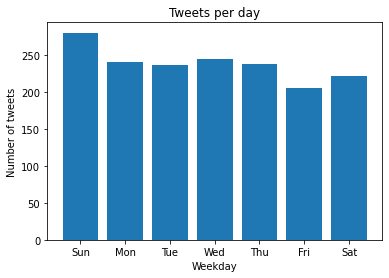

In [52]:
labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
plt.bar(df_best_days['day'], df_best_days['tweets'], tick_label= labels)
plt.title('Tweets per day')
plt.xlabel('Weekday')
plt.ylabel('Number of tweets')